In [1]:
import torchvision
import torch
from torchvision import transforms, models, datasets
from torch import nn, optim
import time
import copy
import torch.nn.functional as F

from sklearn.metrics import f1_score, recall_score,precision_score
from sklearn.metrics import confusion_matrix

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

import pandas as pd
import time

/home/calculo3/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(10)
torch.cuda.manual_seed_all(10)


In [20]:
# Models to choose from [resnet18, resnet34, resnet50, alexnet, vgg11_bn, vgg11, squeezenet, densenet, inception]
model_name = "densenet121"
# Number of classes in the dataset
num_classes = 2
# Number of epochs to train for 
num_epochs = 75

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [22]:
TRAIN_DIR = ""
VALID_DIR = ""
BATCH_SIZE = 24
# Transforms
data_transforms = transforms.Compose([transforms.ToTensor()])
# Load data and create dataloaders
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset = torchvision.datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_feat_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_feat_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=True)
torch.cuda.empty_cache()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


In [23]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    return acc

def f1score(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    y_test2 = y_test.cpu().detach().numpy()
    y_pred_tag2 = y_pred_tag.cpu().detach().numpy()
    f1 = f1_score(y_test2, y_pred_tag2, average ='binary')
    return f1

def precision(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    y_test2 = y_test.cpu().detach().numpy()
    y_pred_tag2 = y_pred_tag.cpu().detach().numpy())
    precision = precision_score(y_test2, y_pred_tag2, average ='binary')
    return precision

def recall(y_pred, y_test, matrix):
    y_pred_tag = torch.round(y_pred)
    y_test2 = y_test.cpu().detach().numpy()
    y_pred_tag2 = y_pred_tag.cpu().detach().numpy()
    recall_sc = recall_score(y_test2, y_pred_tag2, average ='binary')
    return recall_sc

In [24]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True #Retrain all model layers
    else:
        for param in model.parameters():
            param.requires_grad = False #fine-tuning

In [25]:
from torchvision.models import resnet18
from torchvision.models import alexnet
from torchvision.models import vgg16_bn
from torchvision.models import densenet121
from torchvision.models import squeezenet1_0


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = resnet18(weights=None)#.pretrained=use_pretrained
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),   # Cambiamos la capa final a una salida de 1 nodo
            nn.Softmax(1)                  # Agregamos la activación sigmoide
        )
        input_size = 224
        
    elif model_name == "resnet34":
        """ Resnet34
        """
        model_ft= models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))

        input_size = 224    
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))
        input_size = 224  
        
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(weights = 'IMAGENET1K_V1')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))
        input_size = 224

    elif model_name == "vgg11_bn":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))
        input_size = 224
    elif model_name == "vgg11":
        """ VGG11
        """
        model_ft = models.vgg11(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))
        input_size = 224        
    elif model_name == "vgg13_bn":
        """ VGG13_bn
        """
        model_ft = models.vgg13_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))
        input_size = 224       
    elif model_name == "vgg13":
        """ VGG13
        """
        model_ft = models.vgg13(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224  
    elif model_name == "vgg16_bn":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(weights = None) #weights=None#pretrained=use_pretrained
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))
        input_size = 224          
    elif model_name == "vgg16":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))
        input_size = 224  
    elif model_name == "vgg19":
        """ VGG19
        """
        model_ft = models.vgg19(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224         
    elif model_name == "vgg19_bn":
        """ VGG19_bn
        """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224          
    elif model_name == "squeezenet10":
        """ Squeezenet10
        """
        model_ft = models.squeezenet1_0(weights = 'IMAGENET1K_V1')
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        #model_ft.classifier.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))
        input_size = 224
    elif model_name == "squeezenet11":
        """ Squeezenet11
        """
        model_ft = models.squeezenet1_1(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        model_ft.classifier.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))
        input_size = 224        

    elif model_name == "densenet121":
        """ Densenet 121 
        """
        model_ft = models.densenet121(weights = 'IMAGENET1K_V1')#
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        model_ft.classifier.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.4, training=m.training))

        input_size = 224
        
    elif model_name == "densenet161":
        """ Densenet 161 
        """
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224
    elif model_name == "densenet169":
        """ Densenet 169
        """
        model_ft = models.densenet169(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224
    elif model_name == "densenet201":
        """ Densenet 201
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224        
    
    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [26]:
val_acc_history = []
val_recall_history = []
train_acc_history = []
val_f1_history = []
train_f1_history= []
train_loss_history= []
val_loss_history= []

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, is_inception=False):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        preds_all_train = torch.tensor([],dtype = torch.float32)
        labels_all_train = torch.tensor([],dtype = torch.float32)
        preds_all_train = preds_all_train.to("cpu")
        labels_all_train = labels_all_train.to("cpu")

        preds_all_val = torch.tensor([],dtype = torch.float32)
        labels_all_val = torch.tensor([],dtype = torch.float32)
        preds_all_val = preds_all_val.to("cpu")
        labels_all_val = labels_all_val.to("cpu")
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            
            if phase == 'train':
                dataloader = train_loader
            else:
                dataloader = val_loader
            for inputs, labels in dataloader:                
                if phase == 'train':
                    labels_all_train = torch.cat((labels_all_train, labels), 0)
                else:
                    labels_all_val = torch.cat((labels_all_val, labels), 0)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
        
                    _, preds = torch.max(outputs, 1)
                   
                    preds= preds.to("cpu")
                    if phase == 'train':
                        preds_all_train = torch.cat((preds_all_train, preds), 0)
                    else:
                        preds_all_val = torch.cat((preds_all_val, preds), 0)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                labels= labels.to("cpu")
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            if phase == 'train':
                acc_train = binary_acc(preds_all_train, labels_all_train)
                train_acc_history.append(acc_train)
                f1_train = f1score(preds_all_train, labels_all_train)
                train_f1_history.append(f1_train)
                train_loss_history.append(epoch_loss)
                precision_train = precision(preds_all_train, labels_all_train)
                recall_train = recall(preds_all_train, labels_all_train, True)
                tn, fp, fn, tp = confusion_matrix(labels_all_train, preds_all_train).ravel()
                print(phase)
                print("acc: ", acc_train, "f1: ", f1_train, "recall: ", recall_train, "precision: ", precision_train)
                print("tn: ", tn, "fp: ", fp, "fn: ", fn, "tp: ", tp)
            else:
                acc_val = binary_acc(preds_all_val, labels_all_val)
                f1_val = f1score(preds_all_val, labels_all_val)
                precision_val = precision(preds_all_val, labels_all_val)
                recall_val = recall(preds_all_val, labels_all_val, True)
                tn, fp, fn, tp = confusion_matrix(labels_all_val, preds_all_val).ravel()
                print("acc: ", acc_val, "f1: ", f1_val, "recall: ", recall_val, "precision: ", precision_val)
                print("tn: ", tn, "fp: ", fp, "fn: ", fn, "tp: ", tp)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and f1_val > best_acc:
                best_acc = f1_val
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
            if phase == 'val':
                val_recall_history.append(recall_val)
                val_acc_history.append(acc_val)
                val_f1_history.append(f1_val)
                val_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val f1: {:4f}'.format(best_acc))
    print('Best epoch: {:4f}'.format(best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [27]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum =0.9)
#optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [29]:
from torchsummary import summary
#summary(model_ft, (3,224,224))

In [30]:
start_time = time.time()
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
#criterion=nn.BCELoss() 

# Train and evaluate
model_ft, hist = train_model(model_ft, train_loader, valid_loader, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

end_time = time.time()
execution_time = end_time - start_time

print("Tiempo de entrenamiento: {} segundos".format(execution_time))

Epoch 0/74
----------
train
acc:  tensor(0.6486) f1:  0.35101253616200584 recall:  0.2559774964838256 precision:  0.558282208588957
tn:  1060 fp:  144 fn:  529 tp:  182
train Loss: 0.6280 Acc: 0.6486
acc:  tensor(0.7143) f1:  0.4507042253521127 recall:  0.31683168316831684 precision:  0.7804878048780488
tn:  163 fp:  9 fn:  69 tp:  32
val Loss: 0.5594 Acc: 0.7143
Epoch 1/74
----------
train
acc:  tensor(0.7713) f1:  0.6217616580310882 recall:  0.5063291139240507 precision:  0.8053691275167785
tn:  1117 fp:  87 fn:  351 tp:  360
train Loss: 0.5223 Acc: 0.7713
acc:  tensor(0.7985) f1:  0.6927374301675977 recall:  0.6138613861386139 precision:  0.7948717948717948
tn:  156 fp:  16 fn:  39 tp:  62
val Loss: 0.4895 Acc: 0.7985
Epoch 2/74
----------
train
acc:  tensor(0.7984) f1:  0.6897106109324759 recall:  0.6033755274261603 precision:  0.8048780487804879
tn:  1100 fp:  104 fn:  282 tp:  429
train Loss: 0.4564 Acc: 0.7984
acc:  tensor(0.8132) f1:  0.7329842931937172 recall:  0.6930693069306

train
acc:  tensor(0.9248) f1:  0.8887171561051005 recall:  0.8087201125175809 precision:  0.9862778730703259
tn:  1196 fp:  8 fn:  136 tp:  575
train Loss: 0.1503 Acc: 0.9248
acc:  tensor(0.8645) f1:  0.8042328042328043 recall:  0.7524752475247525 precision:  0.8636363636363636
tn:  160 fp:  12 fn:  25 tp:  76
val Loss: 0.3876 Acc: 0.8645
Epoch 24/74
----------
train
acc:  tensor(0.9305) f1:  0.897138437741686 recall:  0.8157524613220816 precision:  0.9965635738831615
tn:  1202 fp:  2 fn:  131 tp:  580
train Loss: 0.1573 Acc: 0.9305
acc:  tensor(0.8755) f1:  0.8210526315789473 recall:  0.7722772277227723 precision:  0.8764044943820225
tn:  161 fp:  11 fn:  23 tp:  78
val Loss: 0.3865 Acc: 0.8755
Epoch 25/74
----------
train
acc:  tensor(0.9253) f1:  0.888888888888889 recall:  0.8045007032348804 precision:  0.9930555555555556
tn:  1200 fp:  4 fn:  139 tp:  572
train Loss: 0.1505 Acc: 0.9253
acc:  tensor(0.8571) f1:  0.7891891891891892 recall:  0.7227722772277227 precision:  0.869047619

train
acc:  tensor(0.9478) f1:  0.9243570347957639 recall:  0.8593530239099859 precision:  1.0
tn:  1204 fp:  0 fn:  100 tp:  611
train Loss: 0.1202 Acc: 0.9478
acc:  tensor(0.8791) f1:  0.8307692307692307 recall:  0.801980198019802 precision:  0.8617021276595744
tn:  159 fp:  13 fn:  20 tp:  81
val Loss: 0.4076 Acc: 0.8791
Epoch 47/74
----------
train
acc:  tensor(0.9410) f1:  0.9145880574452003 recall:  0.8509142053445851 precision:  0.988562091503268
tn:  1197 fp:  7 fn:  106 tp:  605
train Loss: 0.1188 Acc: 0.9410
acc:  tensor(0.8681) f1:  0.8043478260869565 recall:  0.7326732673267327 precision:  0.891566265060241
tn:  163 fp:  9 fn:  27 tp:  74
val Loss: 0.4567 Acc: 0.8681
Epoch 48/74
----------
train
acc:  tensor(0.9394) f1:  0.9111791730474731 recall:  0.8368495077355836 precision:  1.0
tn:  1204 fp:  0 fn:  116 tp:  595
train Loss: 0.1259 Acc: 0.9394
acc:  tensor(0.8681) f1:  0.8105263157894738 recall:  0.7623762376237624 precision:  0.8651685393258427
tn:  160 fp:  12 fn:  24

acc:  tensor(0.8864) f1:  0.835978835978836 recall:  0.7821782178217822 precision:  0.8977272727272727
tn:  163 fp:  9 fn:  22 tp:  79
val Loss: 0.4634 Acc: 0.8864
Epoch 70/74
----------
train
acc:  tensor(0.9342) f1:  0.9029275808936825 recall:  0.8241912798874824 precision:  0.9982964224872232
tn:  1203 fp:  1 fn:  125 tp:  586
train Loss: 0.1132 Acc: 0.9342
acc:  tensor(0.8645) f1:  0.8082901554404146 recall:  0.7722772277227723 precision:  0.8478260869565217
tn:  158 fp:  14 fn:  23 tp:  78
val Loss: 0.4992 Acc: 0.8645
Epoch 71/74
----------
train
acc:  tensor(0.9431) f1:  0.916984006092917 recall:  0.8466947960618847 precision:  1.0
tn:  1204 fp:  0 fn:  109 tp:  602
train Loss: 0.1140 Acc: 0.9431
acc:  tensor(0.8645) f1:  0.8042328042328043 recall:  0.7524752475247525 precision:  0.8636363636363636
tn:  160 fp:  12 fn:  25 tp:  76
val Loss: 0.5028 Acc: 0.8645
Epoch 72/74
----------
train
acc:  tensor(0.9352) f1:  0.9047619047619048 recall:  0.8284106891701828 precision:  0.996615

In [31]:
#----Feature extraction-----#
model_ft.eval()
# Variable global para almacenar las características
features = None

# Hook para capturar las características de la última capa convolucional
def hook_fn(module, input, output):
    global features
    features = output
    
layer4 = model_ft.features[-1]
hook = layer4.register_forward_hook(hook_fn)    


# Almacenar características y etiquetas
data = []
# Iterar sobre el conjunto de datos y extraer características
for inputs, labels in train_feat_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        _ = model_ft(inputs)  
    # Convertir las características a una lista
    flattened_features = features.view(features.size(0), -1).cpu().numpy().tolist()
    # Añadir las características y la etiqueta a los datos
    data.append(flattened_features[0] + [labels.item()])
    

# Eliminar el hook para no afectar futuras operaciones
hook.remove()

# Crear un DataFrame con las características y etiquetas
df = pd.DataFrame(data)
# Nombres de las columnas (las características más la etiqueta)
column_names = [f'feature_{i}' for i in range(len(data[0]) - 1)] + ['label']
df.columns = column_names


In [32]:
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_50167,feature_50168,feature_50169,feature_50170,feature_50171,feature_50172,feature_50173,feature_50174,feature_50175,label
count,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,...,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000
mean,0.000543,0.000979,0.000563,0.000360,0.000552,0.000727,0.000480,0.000825,0.000842,0.000440,...,3.221826,2.834019,0.906368,1.222971,1.251836,1.071717,1.709797,2.319097,1.816041,0.371279
std,0.000622,0.000660,0.000530,0.000456,0.000496,0.000647,0.000616,0.000647,0.000573,0.000463,...,2.753690,2.279102,1.197044,1.505164,1.566256,1.524850,1.912584,2.038939,1.675916,0.483273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000441,0.000027,0.000000,0.000080,0.000109,0.000000,0.000283,0.000404,0.000000,...,1.072152,1.134026,0.000000,0.000000,0.000000,0.000000,0.060681,0.731950,0.506039,0.000000
50%,0.000348,0.000952,0.000482,0.000169,0.000473,0.000641,0.000224,0.000777,0.000792,0.000320,...,2.710081,2.409494,0.485805,0.721340,0.772037,0.426230,1.182960,1.973718,1.467412,0.000000
75%,0.000923,0.001438,0.000897,0.000605,0.000889,0.001147,0.000804,0.001240,0.001211,0.000736,...,4.662485,4.050955,1.356785,1.925339,1.948627,1.667226,2.640308,3.314453,2.662333,1.000000
max,0.003268,0.003373,0.003071,0.003335,0.002678,0.003993,0.003590,0.003438,0.003673,0.002355,...,16.067053,14.868319,9.812912,11.335787,11.967279,14.584314,11.834485,11.987537,10.223947,1.000000


In [33]:
#----EVALUACION----#
model_ft.eval()
# Variable global para almacenar las características
features = None

# Hook para capturar las características de la última capa convolucional
def hook_fn(module, input, output):
    global features
    features = output
    
# Registrar el hook en la última capa convolucional (en ResNet es 'layer4')
layer4 = model_ft.features[-1]
hook = layer4.register_forward_hook(hook_fn)    


# Almacenar características y etiquetas
data = []
# Iterar sobre el conjunto de datos y extraer características
for inputs, labels in valid_feat_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        _ = model_ft(inputs)  
    # Convertir las características a una lista
    flattened_features = features.view(features.size(0), -1).cpu().numpy().tolist()
    # Añadir las características y la etiqueta a los datos
    data.append(flattened_features[0] + [labels.item()])
    

# Eliminar el hook para no afectar futuras operaciones
hook.remove()

# Crear un DataFrame con las características y etiquetas
df = pd.DataFrame(data)
# Nombres de las columnas (las características más la etiqueta)
column_names = [f'feature_{i}' for i in range(len(data[0]) - 1)] + ['label']
df.columns = column_names
if feature_extract == True:
    df.to_csv("/home/calculo3/Documents/Jupyter/featurescnn_ML/pretrained_cnn_features/retrain/"+str(archivo)+"_valid.csv", index=True)
else:
    df.to_csv("/home/calculo3/Documents/Jupyter/featurescnn_ML/pretrained_cnn_features/transf_learn/"+str(archivo)+"_valid.csv", index=True)
   

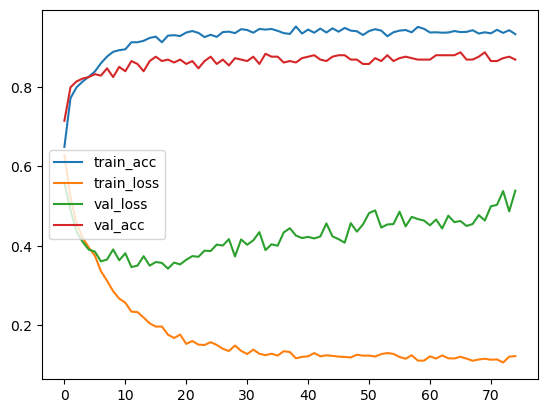

In [34]:
import matplotlib.pyplot as plt
plt.plot(train_acc_history, label = 'train_acc') #Azul
plt.plot(train_loss_history, label = 'train_loss')
plt.plot(val_loss_history, label = 'val_loss')
plt.plot(val_acc_history, label = 'val_acc') #Naranja
#plt.plot(val_recall_history, label = 'val_recall') #verde
#plt.plot(val_f1_history, label = 'val_f1') #rojo
#plt.plot(train_f1_history, label = 'val_f1') #violeta
plt.legend()
plt.savefig("/home/calculo3/Documents/Jupyter/DeepLearning_pruebas/Results/entrenamiento/"+str(archivo)+".png")


todo tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.]) tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.

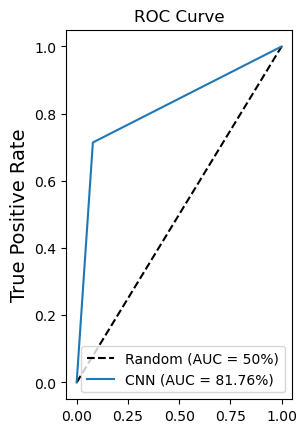

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
TEST_DIR = "/home/calculo3/Documents/DOCTORADO/Datasets/Dataset_2clases_DA/test"

data_transforms = transforms.Compose([transforms.ToTensor()])
# Load data and create dataloaders
test_dataset = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=data_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

test_feat_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

preds_all = torch.tensor([],dtype = torch.float32)
labels_all = torch.tensor([],dtype = torch.float32)
preds_all = preds_all.to("cpu")
labels_all = labels_all.to("cpu")
testSteps = 1
model_ft.eval()
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)
    loss = criterion(outputs, labels)
    #print ("y'",outputs)
    _, preds = torch.max(outputs, 1)
    #print("preds", preds)
    preds = preds.to("cpu")
    labels = labels.to("cpu")
    #print("label", labels)
    preds_all = torch.cat((preds_all, preds), 0)
    labels_all = torch.cat((labels_all, labels), 0)
  
    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

acc_val = binary_acc(preds_all, labels_all)
f1_val = f1score(preds_all, labels_all)
precision_val = precision(preds_all, labels_all)
recall_val = recall(preds_all, labels_all, True)
print("todo",labels_all, preds_all)
tn, fp, fn, tp = confusion_matrix(labels_all, preds_all).ravel()
print("acc: ", acc_val, "f1: ", f1_val, "recall: ", recall_val, "precision: ", precision_val)
print("tn: ", tn, "fp: ", fp, "fn: ", fn, "tp: ", tp)
    
epoch_loss = running_loss / len(test_loader.dataset)
epoch_acc = running_corrects.double() / len(test_loader.dataset)
print('{} Loss: {:.4f} Acc: {:.4f}'.format("test", epoch_loss, epoch_acc))    
tn, fp, fn, tp = confusion_matrix(labels_all, preds_all).ravel()
print(tn, fp, fn, tp)
plt.subplot(122)
fpr, tpr, thresholds = roc_curve(labels_all, preds_all,pos_label = 1.)

print(fpr, tpr)
auc = roc_auc_score(labels_all, preds_all)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
plt.ylabel('True Positive Rate', size=14)
plt.legend(loc='best')
print("auc", auc)


In [36]:
model_ft.eval()
# Variable global para almacenar las características
features = None

# Hook para capturar las características de la última capa convolucional
def hook_fn(module, input, output):
    global features
    features = output
    
# Registrar el hook en la última capa convolucional (en ResNet es 'layer4')
layer4 = model_ft.features[-1]
hook = layer4.register_forward_hook(hook_fn)   

# Almacenar características y etiquetas
data = []
# Iterar sobre el conjunto de datos y extraer características
for inputs, labels in test_feat_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        _ = model_ft(inputs)  
    # Convertir las características a una lista
    flattened_features = features.view(features.size(0), -1).cpu().numpy().tolist()
    # Añadir las características y la etiqueta a los datos
    data.append(flattened_features[0] + [labels.item()])
    

# Eliminar el hook para no afectar futuras operaciones
hook.remove()

# Crear un DataFrame con las características y etiquetas
df = pd.DataFrame(data)
# Nombres de las columnas (las características más la etiqueta)
column_names = [f'feature_{i}' for i in range(len(data[0]) - 1)] + ['label']
df.columns = column_names
